In [1]:
import networkx as nx
from ego_graph_dataset import select_active_graph
from tqdm import tqdm
import pandas as pd
import os
from utils import scores2coalition, PlotUtils
from torch_geometric.utils import to_networkx, from_networkx
import matplotlib.pyplot as plt
import utils
from gspan_mine.gspan_mining.config import parser
from gspan_mine.gspan_mining.main import main

In [9]:
# Build the graph.data file for a given rule
def build_graph_data(dataset='mutagenicity' ,rule=1, metric='entropy', node_selection='fixed_size', nb_graphs=2923):
    graphs = select_active_graph(f'./activ_ego/mutag_{rule}labels_egos.txt', 2,0,[])
    skipped_index = []
    with open(f'results/{dataset}_{rule}_{metric}_{node_selection}.data', 'w+') as f:
        for i in tqdm(range(nb_graphs)):
            graph = to_networkx(graphs[i], to_undirected=True, node_attrs=['center', 'x'])
            df_node_score = pd.read_csv(os.path.join("./results/mutagenicity/gcn/gstarx",
                             f"rule_{rule}/result_{dataset}_{rule}_{i}.csv"))
            if df_node_score is None or len(df_node_score) == 0:
                skipped_index.append(i)
                continue
            node_score = df_node_score[metric].values
            coalition = scores2coalition(node_score, sparsity=0.5, fixed_size=True, size=3)
            # If the node that has the label 'center' to True in the graph is not in the coalition, add it
            for node in graph.nodes():
                if graph.nodes[node]['center'] and node not in coalition:
                    coalition.append(node)
            # Select the subgraph induce by the coalition
            subgraph = graph.subgraph(coalition)
            f.write(f't # {i}\n')
            for node in subgraph.nodes():
                f.write(f'v {int(node)} {graph.nodes[node]["x"]}\n')
            for edge in subgraph.edges():
                f.write(f'e {int(edge[0])} {int(edge[1])} 0\n')
    print(f"Skipped {len(skipped_index)} graphs")

In [10]:
# Build the graph.data file for a given rule
def build_graph_data_neighbors(dataset='mutagenicity' ,rule=1, metric='entropy', node_selection='fixed_size',nb_graph=2923):
    graphs = select_active_graph(f'./activ_ego/mutag_{rule}labels_egos.txt', 2,0,[])
    skipped_index = []
    with open(f'results/{dataset}_{rule}_{metric}_{node_selection}_with_neighbors.data', 'w+') as f:
        for i in tqdm(range(nb_graph)):
            graph = to_networkx(graphs[i], to_undirected=True, node_attrs=['center', 'x'])
            df_node_score = pd.read_csv(os.path.join("./results/mutagenicity/gcn/gstarx",
                             f"rule_{rule}/result_{dataset}_{rule}_{i}.csv"))
            if df_node_score is None or len(df_node_score) == 0:
                skipped_index.append(i)
                continue
            node_score = df_node_score[metric].values
            coalition = scores2coalition(node_score, sparsity=0.5, fixed_size=True, size=3)
            # If the node that has the label 'center' to True in the graph is not in the coalition, add it
            for node in graph.nodes():
                if graph.nodes[node]['center'] and node not in coalition:
                    coalition.append(node)
            # Select the subgraph induce by the coalition
            # Add direct neighbors of the coalition to the coalition without adding nodes that are already in the coalition
            for node in coalition:
                for neighbor in graph.neighbors(node):
                    if neighbor not in coalition:
                        coalition.append(neighbor)
            subgraph = graph.subgraph(coalition)
            f.write(f't # {i}\n')
            for node in subgraph.nodes():
                f.write(f'v {int(node)} {graph.nodes[node]["x"]}\n')
            for edge in subgraph.edges():
                f.write(f'e {int(edge[0])} {int(edge[1])} 0\n')
    print(f"Skipped {len(skipped_index)} graphs")

In [11]:
RULE = 1
DATASET = 'mutagenicity'
METRIC = 'entropy'
NODE_SELECTION = 'split_top'
WITH_NEIGHBORS = True

In [12]:
if WITH_NEIGHBORS:
    build_graph_data_neighbors(DATASET, RULE, METRIC, NODE_SELECTION)
else:
    build_graph_data(DATASET, RULE, METRIC, NODE_SELECTION)

Number of graphs: 2923


100%|██████████| 2923/2923 [00:14<00:00, 208.09it/s]

Skipped 14 graphs


t # 0
v 0 0
v 1 4
e 0 1 0

Support: 2811


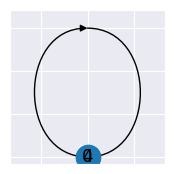


-----------------

t # 1
v 0 0
v 1 0
e 0 1 0

Support: 2554


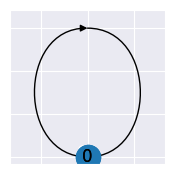


-----------------

t # 2
v 0 0
v 1 0
v 2 4
e 0 1 0
e 1 2 0

Support: 2478


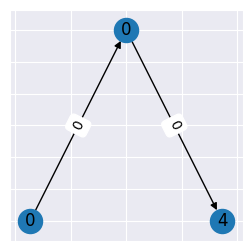


-----------------

t # 3
v 0 0
v 1 0
v 2 0
e 0 1 0
e 1 2 0

Support: 2554


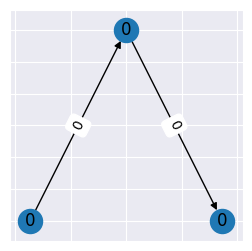


-----------------

t # 4
v 0 0
v 1 0
v 2 0
v 3 4
e 0 1 0
e 1 2 0
e 1 3 0

Support: 2478


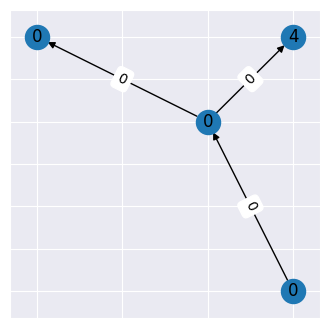


-----------------

Read:	0.08 s
Mine:	1.71 s
Total:	1.79 s


In [15]:
min_support = int(2923 *0.8)
args_str = f'-s {min_support} -p True ./results/{DATASET}_{RULE}_{METRIC}_{NODE_SELECTION}{"_with_neighbors" if WITH_NEIGHBORS else ""}.data'
FLAGS, _ = parser.parse_known_args(args=args_str.split())
gs = main(FLAGS)